In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME
from pandas_profiling import ProfileReport
import pyarrow.feather as feather
import time
from datetime import datetime


In [2]:
export_df = feather.read_feather("../data/cleaned_data.feather")

In [3]:
export_df["event_timestamp"]=pd.to_datetime(export_df["event_timestamp"]*1000, unit="ns")

In [4]:
export_df["notif_viewed_ontime"]=list(map(lambda x,y,z: np.nan if x=="notification_received" else (1 if y < z else 0), export_df["event_name"], export_df["event_timestamp"],export_df["closed_at"])) #1 if the user view it on time  0 if not  and null if hasnt yet seen it 


In [5]:
export_df['user_id'].nunique()

17886

In [6]:

export_df.dropna ( subset=['notif_viewed_ontime'], inplace=True)
export_df.reset_index(drop=True, inplace=True)
export_df["notif_viewed_ontime"]=export_df["notif_viewed_ontime"].astype(int)

In [7]:

export_df["reaction_time"]=list(map(lambda x,y,z,w: float(pd.Timedelta(y - z).seconds/60)
if (x==1) else float(pd.Timedelta(y - w).seconds/60), 
export_df["notif_viewed_ontime"],export_df["event_timestamp"],export_df["created_at"],export_df["closed_at"]))


In [11]:
active_df.loc[active_df['event_name'].isin(['notification_opened', 'notification_view_alternatives' ,  'notification_share']),'opened']= 1
active_df.loc[active_df['event_name'].isin(['notification_received', 'notification_dismiss']),'opened']= 0
active_df['opened']=active_df['opened'].astype(int)


In [8]:
export_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908723 entries, 0 to 908722
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   event_timestamp                       908723 non-null  datetime64[ns]
 1   event_name                            908723 non-null  object        
 2   user_id                               908723 non-null  object        
 3   document_id                           908723 non-null  object        
 4   surrogate_id                          908723 non-null  object        
 5   created_at                            908723 non-null  datetime64[ns]
 6   published_at                          908723 non-null  datetime64[ns]
 7   closed_at                             908060 non-null  datetime64[ns]
 8   cause                                 908723 non-null  object        
 9   effect                                908723 non-null  obje

In [9]:
#!pip install -U spacy
#!pip install -U pip setuptools wheel
#!python -m spacy download en_core_news_sm
#!python -m spacy download es_core_news_sm
#!pip install spacymoji

import spacy
from spacymoji import Emoji
import string
import re


In [10]:
export_df['description'] = export_df['description'].astype('string')

In [11]:
export_df['lenght'] = len(export_df['description'])

In [16]:
nlp = spacy.load('es_core_news_sm')
nlp.add_pipe("emoji", first=True)
emoji= Emoji(nlp)

In [17]:
emoji

In [84]:
def adding_emoji(x):
    emolist=[]
    doc = nlp(x)
    print(x)
    print (doc)
    for i in doc:
        if  i._.has_emoji is True:
            emolist.append(i)
    for e in x:
        print(e)
    #export_df['emoji']= doc._.emoji
   # doc = nlp(x)df['emojis'][i] = doc._.emoji

    return export_df['emoji']

In [85]:
export_df['emoji']= export_df["description"].apply(lambda x: get_emoji(x))

 accidente vehicular en Periférico  poco antes Paseo de las Palmas, en dirección a Reforma.
✋ ¡Tómalo en cuenta! Servicio provisional por manifestantes de Indios Verdes-Reforma, El Caminero-Sonora y de Indios Verdes a Santa Cruz Atoyac en la línea 1 del Metrobús.
✋ Se restablece la circulación de Av. Insurgentes a partir de Puebla, luego de manifestantes.
⏳ ¡Changos! Retrasos por percance en Av. Insurgentes Norte a la altura de Héroes Ferrocarrileros.
🚇 ¡Hora de escuchar que rolitas nuevas salieron! Usuarios reportan retrasos en la línea 1 del Metro, rumbo a Pantitlán. 
⏳ ¡Ponte al tiro! Hay retrasos por accidente vehicular en Circuito Interior después de la Raza, rumbo a la Calz. Guadalupe.
⏳ ¡Anticípate! Hay retrasos por servicios de emergencia en Calle Rossini y Eje Central L. Cárdenas.
⏳ ¡Ah jijo! Hay retrasos por accidente vehicular en Calz. de los Misterios a la altura de Granados, rumbo a Eje 2 Norte.
⏳ Cómprate un té de pasiflora porque el avance de los trenes es lento en las l

KeyboardInterrupt: 

In [ ]:
export_df



In [ ]:
def no_emoji (x):
    doc=nlp(x)
    

In [ ]:
export_df['description_noemoji']= export_df["description"].apply(lambda x: no_emoji(x))

In [9]:
active_df.describe()

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time
count,584293.000000,584293.000000,908723.000000,908723.000000,908723.000000,908723.000000,908723.000000,908723.0,908723.000000,908723.0,908723.000000,908723.000000,908723.000000,908723.000000,908060.000000
mean,-99.132993,19.412858,0.008122,0.447737,0.012590,0.300901,0.177653,0.0,0.036584,0.0,0.000458,0.001115,0.605955,0.579917,117.079080
std,0.053488,0.061724,0.089758,0.497261,0.111498,0.458650,0.382220,0.0,0.187739,0.0,0.021391,0.033369,0.488645,0.493572,226.508678
min,-99.384879,19.181813,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-99.169431,19.373042,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.850000
50%,-99.141207,19.418486,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,30.883333
75%,-99.098607,19.441254,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,104.016667
max,-98.880082,19.851115,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1439.983333


In [10]:
active_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908723 entries, 0 to 908722
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   event_timestamp                       908723 non-null  datetime64[ns]
 1   event_name                            908723 non-null  object        
 2   user_id                               908723 non-null  object        
 3   document_id                           908723 non-null  object        
 4   surrogate_id                          908723 non-null  object        
 5   created_at                            908723 non-null  datetime64[ns]
 6   published_at                          908723 non-null  datetime64[ns]
 7   closed_at                             908060 non-null  datetime64[ns]
 8   cause                                 908723 non-null  object        
 9   effect                                908723 non-null  obje

In [13]:
gpbyuser= active_df.groupby( by= ['user_id'])
gpbyuser2=gpbyuser.sum()
gpbyuser2['count1'] = gpbyuser.size()
gpbyuser2['opened_rate'] = gpbyuser2['opened']/gpbyuser2['count1']
gpbyuser2['ontime_activity_rate'] = gpbyuser2["notif_viewed_ontime"]/gpbyuser2['count1']
gpbyuser2

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time,opened,count1,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,,
00087,-1684.767232,330.804900,0.0,8.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0,14,278.766667,0,17,0.000000,0.823529
00117,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,77.766667,0,4,0.000000,0.750000
001e1,-1686.475347,328.643503,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16,345.316667,0,17,0.000000,0.941176
00205,-1784.841298,349.420908,0.0,18.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,18.0,1,9337.500000,6,18,0.333333,0.055556
0026c,-1586.079503,311.013728,0.0,11.0,0.0,8.0,2.0,0.0,2.0,0.0,0.0,0.0,16.0,2,7689.466667,2,24,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff2a,-17638.600783,3458.458357,0.0,144.0,0.0,136.0,3.0,0.0,19.0,0.0,0.0,0.0,176.0,248,7980.416667,0,302,0.000000,0.821192
fff48,-3766.492158,736.428435,5.0,27.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,38.0,23,2534.350000,1,41,0.024390,0.560976
fff4d,0.000000,0.000000,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,787.550000,2,8,0.250000,0.500000


In [14]:
gpbyuser2.drop(gpbyuser2[gpbyuser2['count1'] <3 ].index, inplace=True  )
real_users=gpbyuser2.index.tolist()
real_users
gpbyuser2

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time,opened,count1,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,,
00087,-1684.767232,330.804900,0.0,8.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0,14,278.766667,0,17,0.000000,0.823529
00117,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,77.766667,0,4,0.000000,0.750000
001e1,-1686.475347,328.643503,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16,345.316667,0,17,0.000000,0.941176
00205,-1784.841298,349.420908,0.0,18.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,18.0,1,9337.500000,6,18,0.333333,0.055556
0026c,-1586.079503,311.013728,0.0,11.0,0.0,8.0,2.0,0.0,2.0,0.0,0.0,0.0,16.0,2,7689.466667,2,24,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff2a,-17638.600783,3458.458357,0.0,144.0,0.0,136.0,3.0,0.0,19.0,0.0,0.0,0.0,176.0,248,7980.416667,0,302,0.000000,0.821192
fff48,-3766.492158,736.428435,5.0,27.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,38.0,23,2534.350000,1,41,0.024390,0.560976
fff4d,0.000000,0.000000,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,787.550000,2,8,0.250000,0.500000


In [15]:
real_users=gpbyuser2.index.tolist()
len(real_users)

10642

In [16]:
active_df=active_df[active_df['user_id'].isin(real_users)]

In [17]:
active_df.user_id.nunique()

10642

In [25]:
gpbyincident= active_df.groupby( by= ['document_id', 'description','cause', 'effect'])
gpbyincident2=gpbyincident.sum()
gpbyincident2['count1'] = gpbyincident.size()
gpbyincident2['opened_rate'] = gpbyincident2['opened']/gpbyincident2['count1']
gpbyincident2['ontime_activity_rate'] = gpbyincident2["notif_viewed_ontime"]/gpbyincident2['count1']




In [23]:
gpbycause= active_df.groupby( by= ['cause'])
gpbycause2=gpbycause.sum()
gpbycause2['count1'] = gpbycause.size()
gpbycause2['opened_rate'] = gpbycause2['opened']/gpbycause2['count1']
gpbycause2['ontime_activity_rate'] = gpbycause2["notif_viewed_ontime"]/gpbycause2['count1']



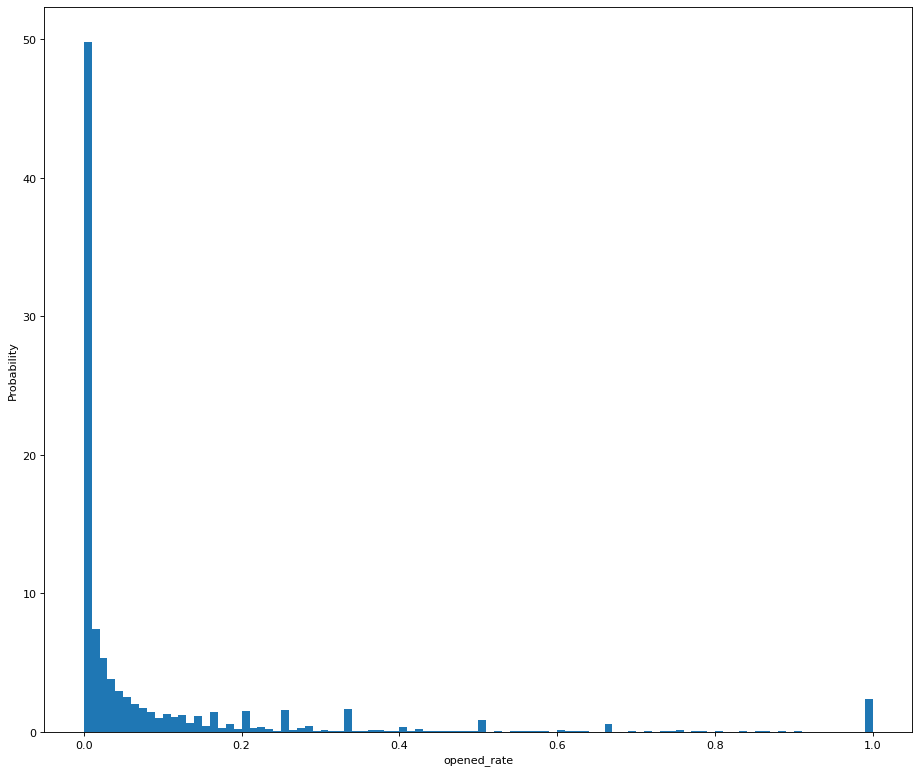

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

x=gpbyuser2.opened_rate

figure(figsize=(14, 12), dpi=80)
plt.hist(x, density=True, bins=100)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('opened_rate');

In [26]:
gpbyuser_dismissers= gpbyuser2.loc[gpbyuser2['opened_rate']== 0 ]
gpbyuser_dismissers

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time,opened,count1,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,,
00087,-1684.767232,330.804900,0.0,8.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0,14,278.766667,0,17,0.0,0.823529
00117,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,77.766667,0,4,0.0,0.750000
001e1,-1686.475347,328.643503,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16,345.316667,0,17,0.0,0.941176
002f1,-297.426877,58.184144,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2550.566667,0,5,0.0,0.000000
002fa,-297.701659,58.497048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,139.716667,0,3,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd86,-693.858813,137.385153,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,12,3652.716667,0,22,0.0,0.545455
ffedf,0.000000,0.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,411.050000,0,4,0.0,1.000000
fff2a,-17638.600783,3458.458357,0.0,144.0,0.0,136.0,3.0,0.0,19.0,0.0,0.0,0.0,176.0,248,7980.416667,0,302,0.0,0.821192


In [27]:
gpbyuser_openers= gpbyuser2.loc[gpbyuser2['opened_rate']== 1]
gpbyuser_openers

,area_of_effect_coordinates_latitude,area_of_effect_coordinates_longitude,agency_GewRJAw5tUmC4Ku4AX1-SQ,agency_GtvOEQAFZ0GtU6u4AXwvPg,agency_HE59N3RXM0q5vKu4AXlQZg,agency_JUR9bFXmVkWDHqu4AXaY0g,agency_JfA8Bw8Zp024Kqu4AXiSpQ,agency_MgUq5b9mOEunx6u4AXt_BA,agency_NuuRQ2I1Q0a50Kv-AVKlLA,agency_V2AIQQKgmUO3VazvAOA-Cw,agency_jLjibFoim0iwWau4AWoEdQ,agency_pky7jovXYkaw-awAAMrQ3g,agency_zCy9zG00HEqGeKu4AWZYNQ,notif_viewed_ontime,reaction_time,opened,count1,opened_rate,ontime_activity_rate
user_id,,,,,,,,,,,,,,,,,,,
0072a,-198.225494,38.964150,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3,193.966667,4,4,1.0,0.750000
00de8,-99.128561,19.481313,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,48.850000,3,3,1.0,1.000000
00f03,-297.434092,58.370746,0.0,2.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,3.0,11,78.050000,11,11,1.0,1.000000
02423,0.000000,0.000000,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,326.233333,3,3,1.0,0.666667
02aa0,-99.209317,19.460743,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,136.966667,3,3,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd695,-495.775587,97.116459,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,7,150.916667,7,7,1.0,1.000000
ff2ac,-99.079372,19.451504,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,43.033333,3,3,1.0,1.000000
ff623,-297.435218,57.949825,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2,237.716667,5,5,1.0,0.400000


In [28]:
gpbyuser_openers['count1'].sort_values().value_counts()

3     73
4     49
5     29
6     20
8     17
7     15
10     8
11     8
9      6
13     4
16     3
19     3
12     2
14     2
17     2
18     2
24     1
26     1
27     1
44     1
62     1
Name: count1, dtype: int64

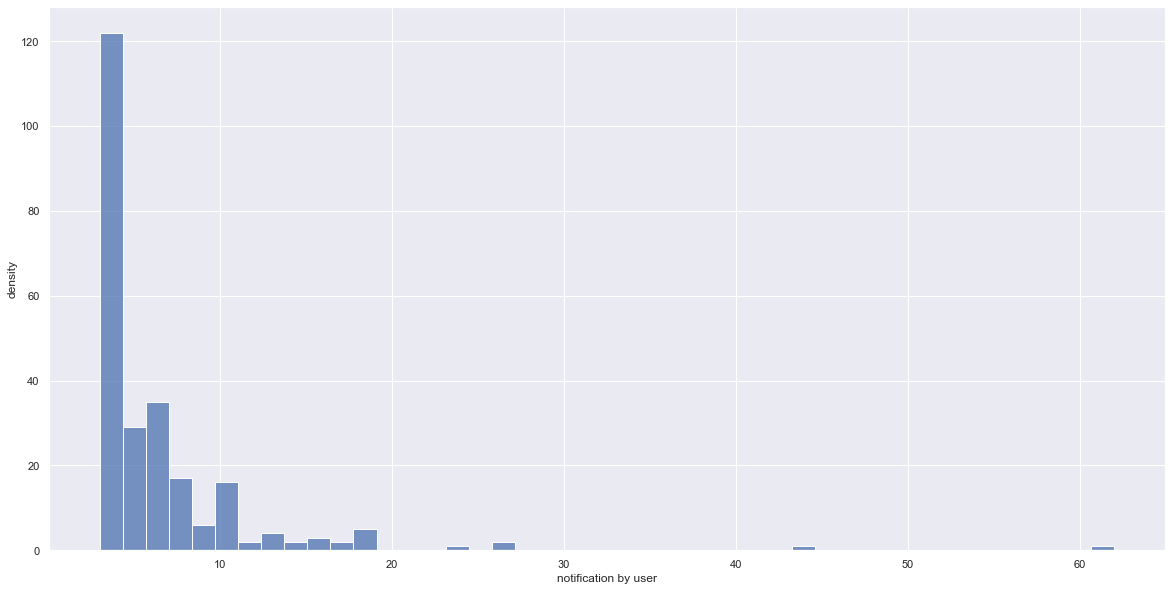

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

x=gpbyuser_openers['count1']

sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x)
plt.ylabel('density')
plt.xlabel('notification by user');

In [29]:
!pip3 install pandas-profiling
from pandas_profiling import ProfileReport
profexport = ProfileReport(active_df)
profexport.to_file(output_file='profexport.html')


Summarize dataset:  75%|███████▌  | 30/40 [06:10<00:52,  5.28s/it, Calculate kendall correlation] /Users/chrisgilibert/neuefische/Capstone-WIMT/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/chrisgilibert/neuefische/Capstone-WIMT/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4596: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var) / np.sqrt(2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 85.13it/s]


In [30]:
profincident = ProfileReport(gpbyincident2)
profincident.to_file(output_file='profincident.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


In [31]:
profcause = ProfileReport(gpbycause2)
profcause.to_file(output_file='profcause.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


In [32]:
profallusers= ProfileReport(gpbyuser2)
profallusers.to_file(output_file='profallusers.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


In [33]:
profusersdismiss= ProfileReport(gpbyuser_dismissers)
profusersdismiss.to_file(output_file='profusersdismiss.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


In [34]:
profusersopen= ProfileReport(gpbyuser_openers)
profusersopen.to_file(output_file='profusersopen.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]
